In [1]:
from google.colab import files 
upload=files.upload()

Saving HandGesture.zip to HandGesture.zip


In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
!unzip "/content/HandGesture.zip" -d "/content/HandGesture/"

Archive:  /content/HandGesture.zip
replace /content/HandGesture/HandGesture/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [71]:
import numpy as np 
import pandas as pd
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.image import load_img,img_to_array 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import classification_report,log_loss,accuracy_score 
from sklearn.model_selection import train_test_split

In [72]:
directory='/content/HandGesture/HandGesture/images'
Name=[]
for file in os.listdir(directory): 
  if file!= '.DS_Store':
    Name+=[file]
print(Name)
print(len(Name))

['rock_on', 'call_me', 'fingers_crossed', 'paper', 'okay', 'thumbs', 'scissor', 'rock', 'peace', 'up']
10


In [73]:
N=[]
for i in range(len(Name)): 
  N+=[i]
 
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value): 
  return reverse_mapping[value]

In [74]:
File=[] 
for file in os.listdir(directory): 
  if file!= '.DS_Store':
    File+=[file]

print(File)

['rock_on', 'call_me', 'fingers_crossed', 'paper', 'okay', 'thumbs', 'scissor', 'rock', 'peace', 'up']


In [75]:
# select the first 4000 images into our training set to do model selection
# the rest images are for the test purpose of our final model
dataset=[]
testset=[]
count=0
for file in File:
  path=os.path.join(directory,file)
  t=0
  for im in os.listdir(path):
    if im[len(im)-2:]!='pt.m' and im[len(im)-2:]!='.txt': 
      image=load_img(os.path.join(path,im),grayscale=False,color_mode='rgb', target_size=(60,60))
      image=img_to_array(image)
      image=image/255.0 
      if t<400: 
        dataset.append([image,count]) 
      else: 
        testset.append([image,count]) 
      t+=1
  count=count+1


In [76]:
data,labels0=zip(*dataset) 
test,tlabels0=zip(*testset)
print(np.unique(data))

[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.9647059  0.96862745 0.972549
 0.9764706  0.98039216 0.9843137  0.9882353  0.99215686 0.99607843
 1.        ]


In [77]:
# build the training set 
labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)
print(len(labels))

4000


In [78]:
# build the test set for th test of the final model
tlabels1=to_categorical(tlabels0)
test=np.array(test)
tlabels=np.array(tlabels1)
print(len(tlabels))

1243


In [79]:
# Further split the training set to 60:20:20 and apply to 3 models, 
# the 1243 images in the testset will not be used until we choose the final model among AlexNet, VGG16, and ResNet
trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=123) 
trainx,valx,trainy,valy=train_test_split(trainx,trainy,test_size=0.25,random_state=123)

In [80]:
print(trainx.shape) 
print(testx.shape) 
print(trainy.shape) 
print(testy.shape)
print('---------')
print(test.shape)
print(tlabels.shape)

(2400, 60, 60, 3)
(800, 60, 60, 3)
(2400, 10)
(800, 10)
---------
(1243, 60, 60, 3)
(1243, 10)


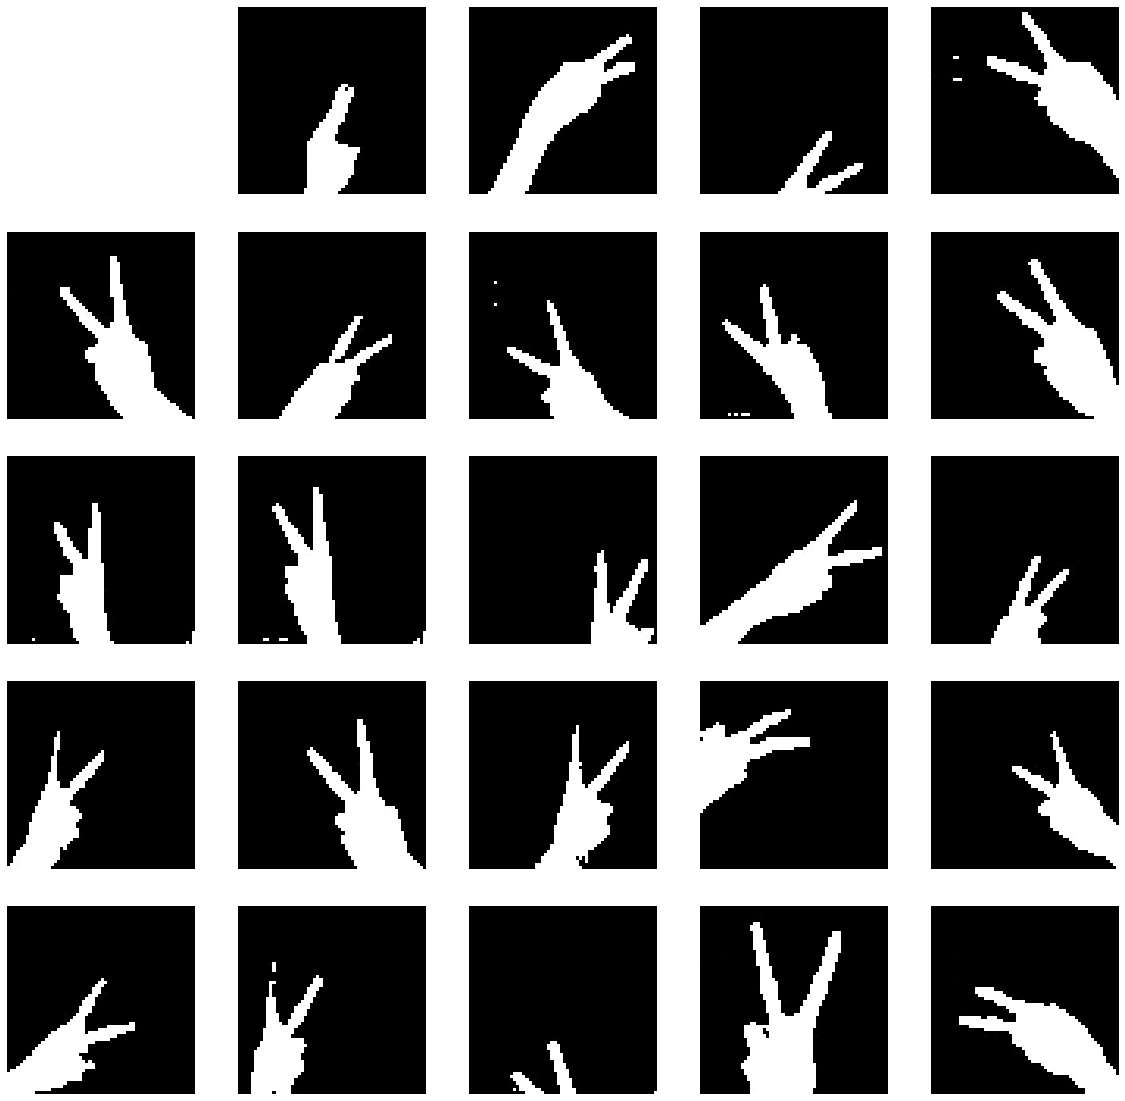

In [89]:
plt.figure(figsize=(20,20)) 
# show the first 25 images in the dataset with first label
for i,image in enumerate(data):
  if i <=2500:
    continue 
  if i == 2525:
    break
  ax=plt.subplot(5,5,i-2500+1) 
  plt.imshow(image) 
  plt.axis('off')

In [90]:
def process_images(image,label): #Normalize images to have a mean of 0 and standard deviation of 1 
  image=tf.image.per_image_standardization(image) 
  #Resize images from to 277x277 for AlexNet input
  image=tf.image.resize(image,(227,227))
  return image,label

trainx,trainy=process_images(trainx,trainy) 
testx,testy=process_images(testx,testy) 
valx,valy=process_images(valx,valy)
test,tlabels=process_images(test,tlabels)

print(trainx.shape) 
print(testx.shape) 
print(trainy.shape) 
print(testy.shape)
print('---------')
print(test.shape)
print(tlabels.shape)

(2400, 227, 227, 3)
(800, 227, 227, 3)
(2400, 10)
(800, 10)
---------
(1243, 227, 227, 3)
(1243, 10)


In [91]:
# Build AlexNet and add batch normalization layers after every convolutional layers
from keras.models import Sequential
import keras
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical

# Sequential model
model = Sequential()
# input image 227*227*3, 96*(11*11) kernals, stride = 4， no padding, activation = 'relu'
model.add(Conv2D(96, (11, 11), strides=(4, 4), input_shape=(227, 227, 3), activation='relu',
                 kernel_initializer='uniform'))
model.add(keras.layers.BatchNormalization())
# maxpooling
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
# 245*(5*5) kernals, padding, activation = 'relu'
model.add(Conv2D(256, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(keras.layers.BatchNormalization())
# maxpooling, s=2
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
# 384*(3*3) kernals
model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(keras.layers.BatchNormalization())
model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(keras.layers.BatchNormalization())
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                      

In [92]:
history = model.fit(trainx,trainy,epochs=14,batch_size=32,validation_data=(valx,valy))

Epoch 1/14
75/75 [==============================] - 5s 59ms/step - loss: 3.1644 - accuracy: 0.4246 - val_loss: 3.8482 - val_accuracy: 0.1612
Epoch 2/14
75/75 [==============================] - 4s 52ms/step - loss: 0.7426 - accuracy: 0.7417 - val_loss: 0.4960 - val_accuracy: 0.8275
Epoch 3/14
75/75 [==============================] - 4s 54ms/step - loss: 0.4544 - accuracy: 0.8421 - val_loss: 0.2320 - val_accuracy: 0.9250
Epoch 4/14
75/75 [==============================] - 4s 52ms/step - loss: 0.2733 - accuracy: 0.9017 - val_loss: 0.1807 - val_accuracy: 0.9362
Epoch 5/14
75/75 [==============================] - 4s 55ms/step - loss: 0.1527 - accuracy: 0.9517 - val_loss: 0.1420 - val_accuracy: 0.9475
Epoch 6/14
75/75 [==============================] - 4s 52ms/step - loss: 0.1092 - accuracy: 0.9658 - val_loss: 0.0814 - val_accuracy: 0.9762
Epoch 7/14
75/75 [==============================] - 4s 55ms/step - loss: 0.0978 - accuracy: 0.9658 - val_loss: 0.0790 - val_accuracy: 0.9700
Epoch 8/14
75

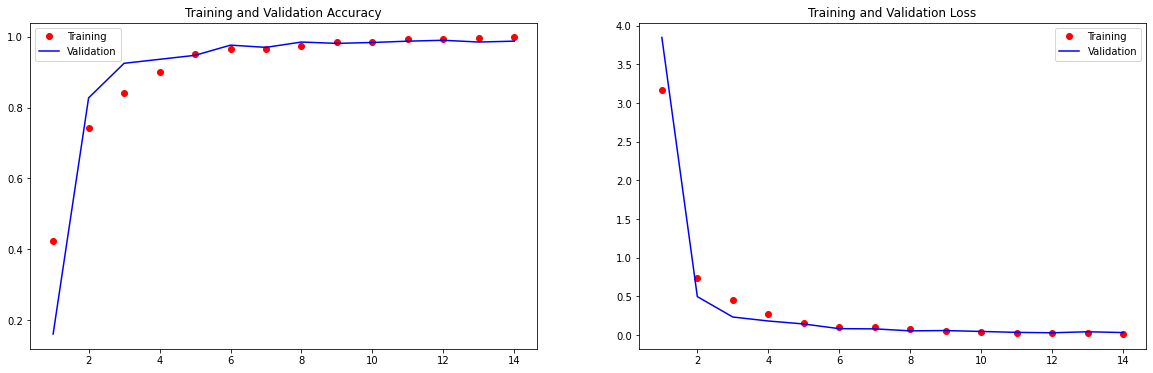

In [93]:
# plot the trainging and validation accuracy and loss
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure(figsize=(20,6))
ax = plt.subplot(121)
plt.title("Training and Validation Accuracy")
ax.plot(epochs, acc,'or',label = 'Training')
ax.plot(epochs, val_acc,'b',label = 'Validation')
ax.legend()

ax1 = plt.subplot(122)
plt.title("Training and Validation Loss")
ax1.plot(epochs, loss,'or',label = 'Training')
ax1.plot(epochs, val_loss,'b',label = 'Validation')
ax1.legend()
plt.show()

25/25 [==============================] - 1s 23ms/step - loss: 0.0418 - accuracy: 0.9862
Testloss: 0.04182080924510956
Testaccuracy: 0.9862499833106995


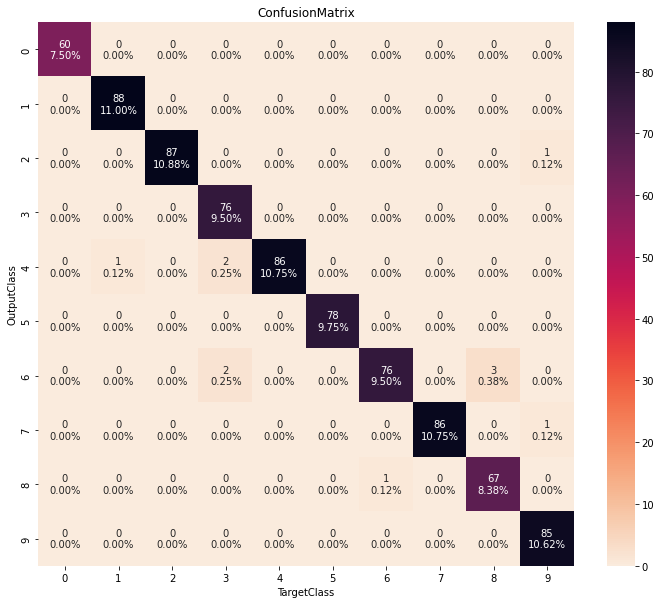

In [94]:
import seaborn as sn
import numpy as np 
import matplotlib.pyplot as plt 
def plot_confusion_matrix(y_classified,y_true):
#Computeconfusionmatrix 
  c_mat=np.zeros((testy.shape[1],testy.shape[1])) 
  for i in range(len(y_true)): 
    c_mat[y_classified[i],y_true[i]]+=1
  
  group_counts=["{0:0.0f}".format(value) for value in c_mat.flatten()] 
  group_percentages=["{0:.2%}".format(value) for value in c_mat.flatten()/np.sum(c_mat)]
  labels =[f"{v1}\n{v2}"for v1,v2 in zip(group_counts,group_percentages)] 
  labels=np.asarray(labels).reshape(c_mat.shape[0],c_mat.shape[1])

  plt.figure(figsize=(12,10)) 
  sn.heatmap(c_mat,annot=labels,fmt='',cmap='rocket_r') 
  plt.title("ConfusionMatrix")
  plt.ylabel('OutputClass')
  plt.xlabel('TargetClass') 

#Evaluate the trained model using keras built‐in function 
score=model.evaluate(testx,testy,verbose=1)
print("Testloss:",score[0])
print("Testaccuracy:",score[1])

y_classified=np.argmax(model.predict(testx),axis=1) 
y_true=np.argmax(testy,axis=1)
#plot confusion matrix
plot_confusion_matrix(y_classified,y_true)

39/39 [==============================] - 1s 23ms/step - loss: 0.0397 - accuracy: 0.9903
Testloss: 0.039696406573057175
Testaccuracy: 0.9903459548950195


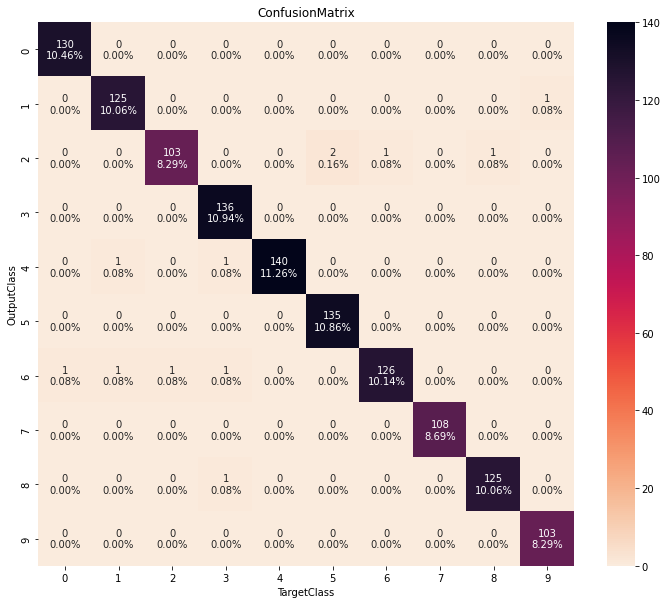

In [95]:
# After decide on the AlexNet model as our final model, use the original 1243 testset as our final test result
score=model.evaluate(test,tlabels,verbose=1)
print("Testloss:",score[0])
print("Testaccuracy:",score[1])

y_classified=np.argmax(model.predict(test),axis=1) 
y_true=np.argmax(tlabels,axis=1)
#plot confusion matrix
plot_confusion_matrix(y_classified,y_true)